In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns

# Add src directory to system path
project_path = os.getcwd().split('/src')[0]
sys.path.append(project_path)

print(project_path)

plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

try:
    from src.models.run import Run
    from src.utils.functions import gaussian
    from src.utils.functions import decay
    from src.utils.functions import hist_to_scatter
    from src.utils.functions import remove_nans
except Exception as e:
    print("Failed to import local modules:")
    print(e)

# Define important paths
lcd_path  = os.path.join(project_path, 'lcd')
out_path  = os.path.join(project_path, 'out')
plt_path  = os.path.join(project_path, 'plt')

a1 = np.load(os.path.join(out_path, "a1.npy"))
a2 = np.load(os.path.join(out_path, "a2.npy"))
a3 = np.load(os.path.join(out_path, "a3.npy"))

/home/hargy/Science/Projects/sci-muons_gesher_v2


In [2]:
# Boundaries
SN1 = 631

WE1 = 725
WE2 = WE1 + 743
WE3 = WE2 + 690

"""
sn1 = ((a2[:SN1] / 3600) + 16.63 - off) 
sn2 = ((a2[SN1:] / 3600) + 15.1 - off ) 

we1 = ((a3[:WE1] / 3600) + 7.7 - off)
we2 = ((a3[WE1:WE2] / 3600) + 7.3 - off)
we3 = ((a3[WE2:WE3] / 3600) + 6.9 - off)
we4 = ((a3[WE3:] / 3600) + 7.3 - off)
"""

# a2, a3 are the timesatmps from the first event at t=0, in seconds.
# Define midnight 00:00 as t=0.

def conv_to_hrs(arr, init):
    new_arr = (arr / 3600) + init
    return new_arr

def find_closest(array, value):
    return array[np.abs(array - value).argmin()]

def correct_hist(arr, hist, hist_errs):

    # First edge
    t1 = arr[0]
    if int(t1)%2==0:
        first_hour = int(t1)
    else:
        first_hour = int(t1) - 1

    second_hour = first_hour + 2
    
    bin_idx = int(first_hour/2)
    freq_first    = hist[bin_idx]
    corr_freq_first = (freq_first / (second_hour - t1))*2
    err_first = (np.sqrt(freq_first) / (second_hour - t1) ) *2

    print(t1, second_hour, freq_first, corr_freq_first, err_first)
        
    hist[bin_idx] = corr_freq_first
    hist_errs[bin_idx] = err_first
    
    # Last edge
    tlast = arr[-1]
    if int(tlast)%2==0:
        last_hour = int(tlast)
    else:
        last_hour = int(tlast) - 1

    bin_idx = int(last_hour/2)
    freq_last = hist[bin_idx]
    corr_freq_last = (freq_last / (tlast - last_hour)) * 2
    err_last = (np.sqrt(freq_last) / (tlast - last_hour)) * 2

    hist[bin_idx] = corr_freq_last
    hist_errs[bin_idx] = err_last

    return hist, hist_errs

sn1 = conv_to_hrs(a2[:SN1], 16.63)
sn2 = conv_to_hrs(a2[SN1:], 15.1)

we1 = conv_to_hrs(a3[:WE1], 7.7)
we2 = conv_to_hrs(a3[WE1:WE2], 7.3)
we3 = conv_to_hrs(a3[WE2:WE3], 6.9)
we4 = conv_to_hrs(a3[WE3:], 7.3)

bin_edges_DEF = np.array(np.arange(0,52,2), dtype=int)
bin_mids = np.array(bin_edges_DEF[:-1] + np.diff(bin_edges_DEF)/2, dtype=int)

sn1_hist = np.histogram(sn1, bins=bin_edges_DEF)[0]
sn1_errs = np.sqrt(sn1_hist)

sn2_hist = np.histogram(sn2, bins=bin_edges_DEF)[0]
sn2_errs = np.sqrt(sn2_hist)

we1_hist = np.histogram(we1, bins=bin_edges_DEF)[0]
we1_errs = np.sqrt(we1_hist)

we2_hist = np.histogram(we2, bins=bin_edges_DEF)[0]
we2_errs = np.sqrt(we2_hist)

we3_hist = np.histogram(we3, bins=bin_edges_DEF)[0]
we3_errs = np.sqrt(we3_hist)

we4_hist = np.histogram(we4, bins=bin_edges_DEF)[0]
we4_errs = np.sqrt(we4_hist)

# Correct
sn1_hist, sn1_errs = correct_hist(sn1, sn1_hist, sn1_errs)
sn2_hist, sn2_errs = correct_hist(sn2, sn2_hist, sn2_errs)

we1_hist, we1_errs = correct_hist(we1, we1_hist, we1_errs)
we2_hist, we2_errs = correct_hist(we2, we2_hist, we2_errs)
we3_hist, we3_errs = correct_hist(we3, we3_hist, we3_errs)
we4_hist, we4_errs = correct_hist(we4, we4_hist, we4_errs)

# patch!
sn1_hist[19] = 0
sn1_errs[19] = 0

data_arr = [[sn1_hist, sn1_errs], [sn2_hist, sn2_errs], [we1_hist, we1_errs], [we2_hist, we2_errs], [we3_hist, we3_errs], [we4_hist, we4_errs]]
dates    = ["11/08", "12/08","18/08","19/08","20/08","21/08"]
oris     = ["S-N", "S-N", "W-E", "W-E", "W-E", "W-E"]
event_num = [631, 1000, 725, 743, 690, 918]
times     = [21.4, 31.7, 23.3, 23.4, 24.0, 29.4]

16.63 18 33 48.17518248175179 8.386222841661349
15.1 16 39 86.66666666666663 13.877773329774213
7.7 8 11 73.33333333333337 22.110831935702677
7.3 8 26 74.28571428571426 14.568627181693666
6.9 8 27 49.09090909090911 9.447549859466607
7.3 8 24 68.57142857142856 13.997084244475298


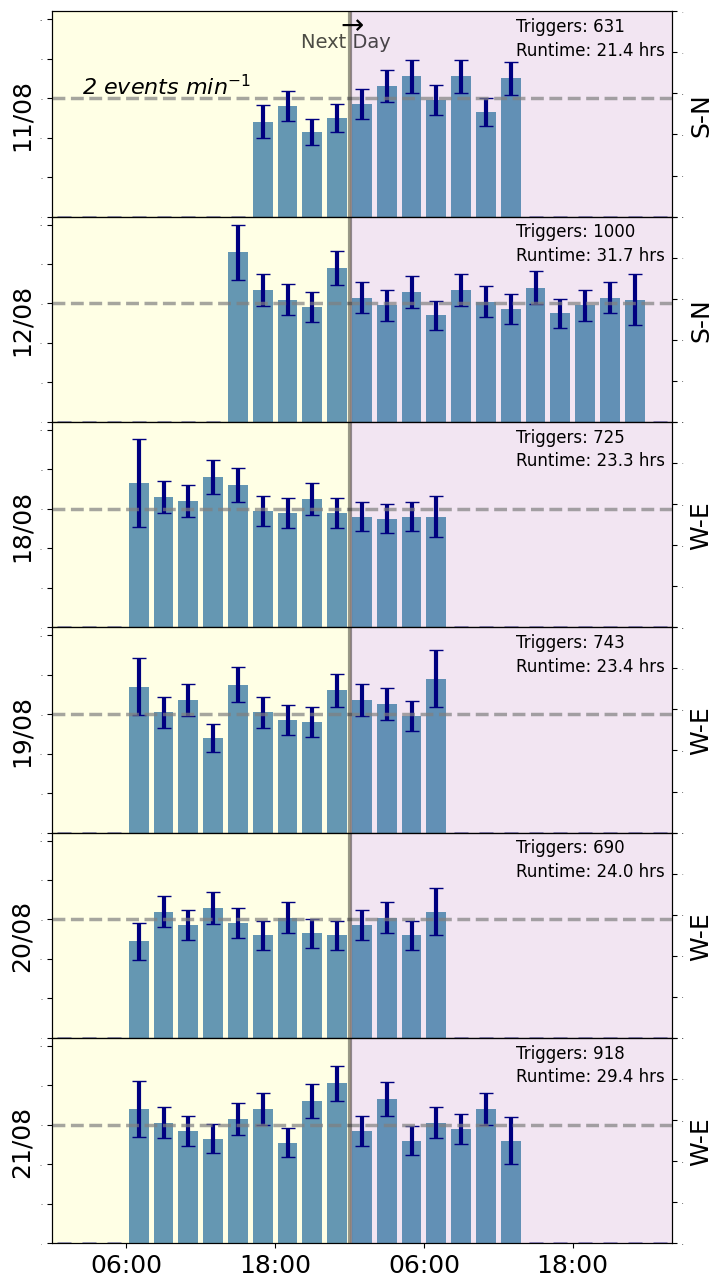

In [3]:
plt.rcParams['ytick.labelsize'] = 0
plt.rcParams['xtick.labelsize'] = 18
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(8,16), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0, wspace=0)

axs[0].set_ylim(0,104)
axs[0].set_xlim(2.5, 26.5)
axs[0].text(0.7, 62, r'2 events min$^{-1}$', style='italic', fontsize = 16)
axs[0].text(10.9, 94, r"$\rightarrow$", fontsize = 20)
axs[0].text(9.55, 86, r"Next Day", fontsize = 14, alpha = 0.7)

for idx, data in enumerate(data_arr):
    hist = data[0]
    err  = data[1]

    axs[idx].text(18.2, 94, f"Triggers: {event_num[idx]}", fontsize = 12)
    axs[idx].text(18.2, 82, f"Runtime: {times[idx]} hrs", fontsize = 12)

    sns.barplot(x=bin_mids, y=hist, ax=axs[idx], alpha = 0.75, zorder = 2)
    x_positions = axs[idx].get_xticks()
    axs[idx].errorbar(x_positions, hist, yerr=err, fmt="none", zorder=2, capsize = 5, lw =3, color='navy')
    axs[idx].set_ylabel(dates[idx], fontsize = 18)
    axs[idx].axhline(60, linestyle = '--', color = 'grey', lw = 2.5, zorder=3, alpha = 0.7)
    axs[idx].axvline(11.5, color='black', zorder = 4, alpha = 0.4, lw = 3)

    axs[idx].axvspan(-1, 11.5, color = 'yellow', alpha = 0.1, zorder =1)
    axs[idx].axvspan(11.5, 25, color = 'purple', alpha = 0.1, zorder =1)

    #axs[idx].legend(fontsize = 14)

    ax2 = axs[idx].twinx()
    ax2.set_ylabel(oris[idx], fontsize = 18)
    
axs[5].set_xticks([2.5,8.5,14.5,20.5], labels = ["06:00", "18:00", "06:00", "18:00"])

plt.savefig("/home/hargy/Downloads/newrates.png", dpi = 450)

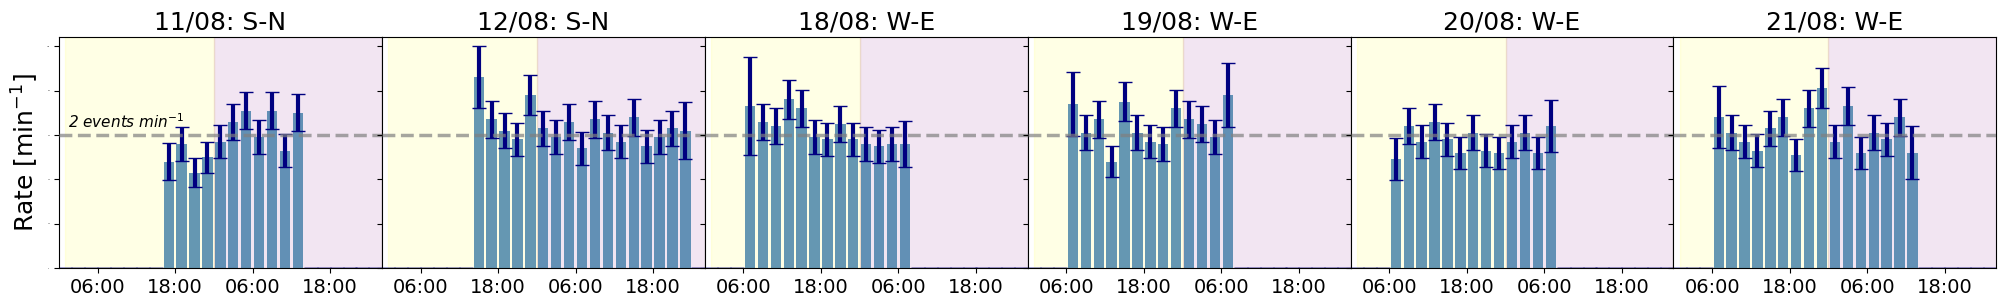

In [4]:
plt.rcParams['ytick.labelsize'] = 0
plt.rcParams['xtick.labelsize'] = 14
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(25,3), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0, wspace=0)

axs[0].set_ylim(0,104)
axs[0].set_xlim(2.5, 26.5)
axs[0].text(0.2, 63, r'2 events min$^{-1}$', style='italic', fontsize = 11)

for idx, data in enumerate(data_arr):
    hist = data[0]
    err  = data[1]

    sns.barplot(x=bin_mids, y=hist, ax=axs[idx], alpha = 0.75, zorder = 2)
    x_positions = axs[idx].get_xticks()
    axs[idx].errorbar(x_positions, hist, yerr=err, fmt="none", zorder=2, capsize = 5, lw =3, color='navy')
    axs[idx].set_title(f"{dates[idx]}: {oris[idx]}", fontsize = 18)
    axs[idx].axhline(60, linestyle = '--', color = 'grey', lw = 2.5, zorder=3, alpha = 0.7)

    axs[idx].axvspan(0, 11.5, color = 'yellow', alpha = 0.1, zorder =1)
    axs[idx].axvspan(11.5, 25, color = 'purple', alpha = 0.1, zorder =1)

    #ax2 = axs[idx].twinx()
    #ax2.set_ylabel(oris[idx], fontsize = 18)
    
axs[5].set_xticks([2.5,8.5,14.5,20.5], labels = ["06:00", "18:00", "06:00", "18:00"])
axs[0].set_ylabel(r"Rate [min$^{-1}$]", fontsize = 18)

plt.savefig("/home/hargy/Downloads/newrates.png", dpi = 450)

114006.4


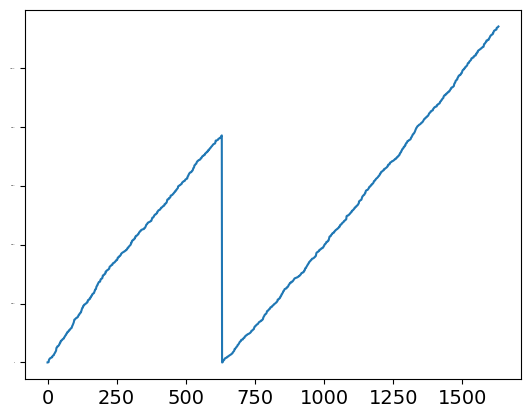

In [5]:
print(a2[-1])
plt.plot(a2)

105770.1


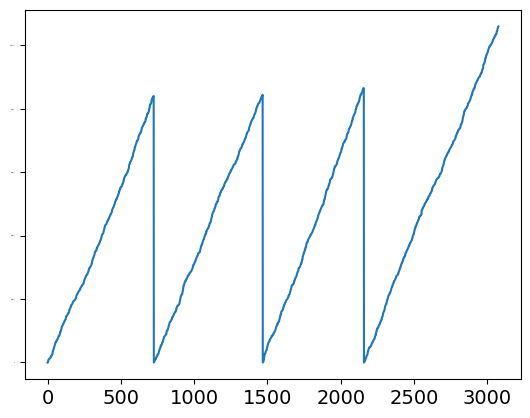

In [6]:
print(a3[(event_num[2]-1) + (event_num[3] -1) + (event_num[4] -1) + (event_num[5] - 1)])
plt.plot(a3)

In [23]:
tot=0
for i in range(1, 12):
    tot+=a1[999*i]
print(tot)

287.7522599999999


In [8]:
print(we2[0])
print(we2_hist)

7.3
[ 0  0  0 74 61 67 48 75 61 57 56 72 67 65 59 78  0  0  0  0  0  0  0  0
  0]


In [9]:
print(we3[0])
print(we3_hist)

6.9
[ 0  0  0 49 64 57 66 58 52 61 53 52 57 61 52 64  0  0  0  0  0  0  0  0
  0]


In [10]:
print(we4[0])
print(we4_hist)

7.3
[ 0  0  0 68 61 57 53 63 68 51 72 81 57 73 52 61 58 68 52  0  0  0  0  0
  0]
